In [36]:
from cycler import cycler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings("ignore")
import random

plt.rcParams["figure.figsize"] = (10, 5)

# sns.set_palette("Greys")
# plt.style.use('dark_background')
random_state=42
random.seed(random_state)

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

PATH_TO_IMG = "../Tesina/Mio/img"
YLIM = (125, 140)

### Leer los datos

In [37]:
tesis = pd.read_csv("../Datos/tesis_final_preprocesado.csv")

In [38]:
tesis_basal = tesis[tesis["Mes"] == 1]

In [39]:
tesis.idPaciente.nunique()

560

In [40]:
tesis.head()

,idPaciente,Mes,TAS,Adherencia,Sexo,Edad,tas_basal,Adherencia_Acumulada,Adherencia_Total,Adherencia_Perfecta,...,Intercept,Adherencia_lag1,TAS_lag1,Adherencia_Acumulada_lag2,TAS_Media_Acumulada_lag2,Mes*Adherencia,Mes*Adherencia_Perfecta,Mes*Adherencia_Total,Mes*Adherencia_lag1,Mes*Adherencia_Acumulada
0,4026,1,119.000000,1,0,76.0,116,1.0,1.0,1,...,1,0.0,116.00000,0.0,116.000000,1,1,1.0,0.0,1.0
1,4026,2,127.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,119.00000,0.0,116.000000,2,2,2.0,2.0,2.0
2,4026,3,140.000000,1,0,76.0,116,1.0,1.0,1,...,1,1.0,127.00000,1.0,119.000000,3,3,3.0,3.0,3.0
3,4026,4,146.712710,1,0,76.0,116,1.0,1.0,1,...,1,1.0,140.00000,1.0,123.000000,4,4,4.0,4.0,4.0
4,4026,5,177.708084,1,0,76.0,116,1.0,1.0,1,...,1,1.0,146.71271,1.0,128.666667,5,5,5.0,5.0,5.0


### Análisis de datos de interés

In [41]:
tesis_basal["Sexo"].mean()

0.4928571428571429

In [42]:
tesis_basal["Edad"].mean(), tesis_basal["Edad"].std(), tesis_basal["Edad"].min(), tesis_basal["Edad"].max()

(58.84714548802947, 9.727992278294579, 30.0, 86.0)

In [43]:
tesis_basal["TAS"].mean(), tesis_basal["TAS"].std()

(132.7047128033101, 15.210185404028245)

### Análisis de la respuesta

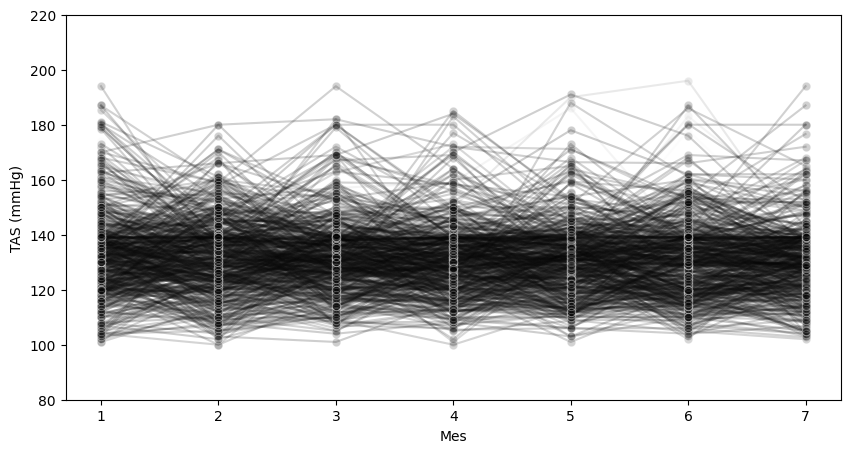

In [44]:
# Gráfico de perfiles individuales
plt.figure(figsize=(10,5))
line = sns.lineplot(x=tesis["Mes"], y=tesis["TAS"], hue=tesis["idPaciente"], marker="o", palette="Greys", alpha=0.2)
# plt.ylim(YLIM)
plt.ylabel("TAS (mmHg)")
line.get_legend().remove()
plt.ylim((80, 220))
# plt.title("Perfil promedio de la TAS a través del tiempo")
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo_perfiles_individuales.png", bbox_inches='tight')

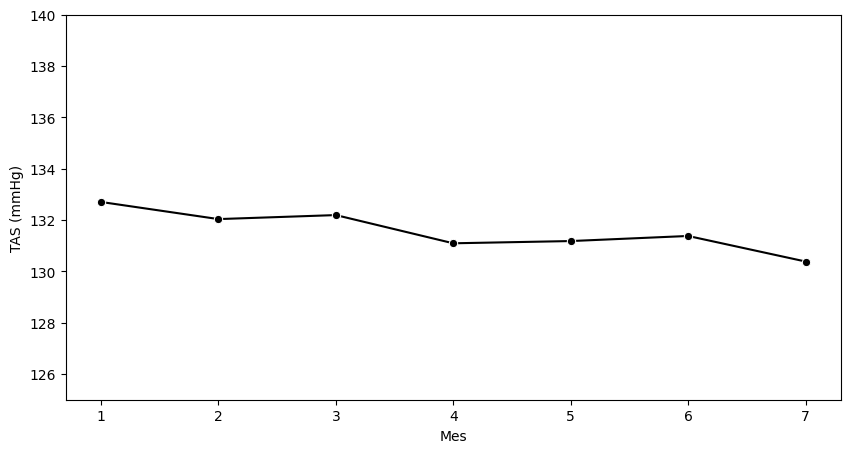

In [45]:
# Gráfico de perfiles promedio
plt.figure(figsize=(10,5))
sns.lineplot(x=tesis["Mes"], y=tesis["TAS"], marker="o", color="black", ci=None)
plt.ylim(YLIM)
plt.ylabel("TAS (mmHg)")
# plt.title("Perfil promedio de la TAS a través del tiempo")
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo.png", bbox_inches='tight')

In [46]:
tesis.groupby("Mes")["TAS"].mean()

Mes
1    132.704713
2    132.037500
3    132.193709
4    131.094594
5    131.181822
6    131.379877
7    130.384654
Name: TAS, dtype: float64

### Análisis bivariado a través del tiempo

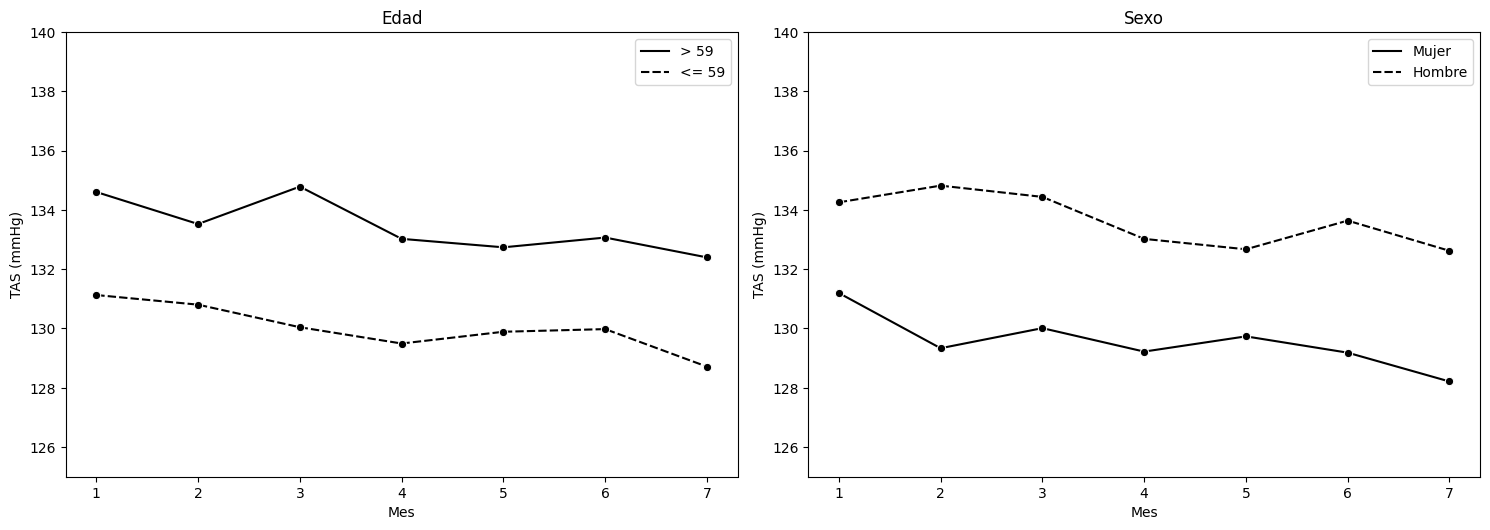

In [47]:
# Covariables importantes
plt.figure(figsize=(15,10))

covs = ["Edad", "Sexo"]
for i, x in enumerate(covs):
    axs = plt.subplot(int(len(covs)/2)+1,2,i+1)
    if x == "Edad":
        median_ = int(tesis.drop_duplicates(["idPaciente", x])[x].median())
        hue_mask = tesis[x] > median_
        hue_mask = hue_mask.map({True: f"> {median_}", False: f"<= {median_}"})
    elif x == "Sexo":
        hue_mask = tesis[x].map({0: "Mujer", 1: "Hombre"})
    line = sns.lineplot(
        x=tesis["Mes"],
        y=tesis["TAS"],
        marker="o",
        hue=hue_mask,
        style=hue_mask,
        palette=["black", "black"],
        ci=None
    )
    plt.legend()
    plt.ylim(YLIM)
    plt.ylabel("TAS (mmHg)")
    plt.title(str(hue_mask.name))

plt.tight_layout()
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo_with_covs.png", bbox_inches='tight')
plt.show()

### Análisis de Adherencia

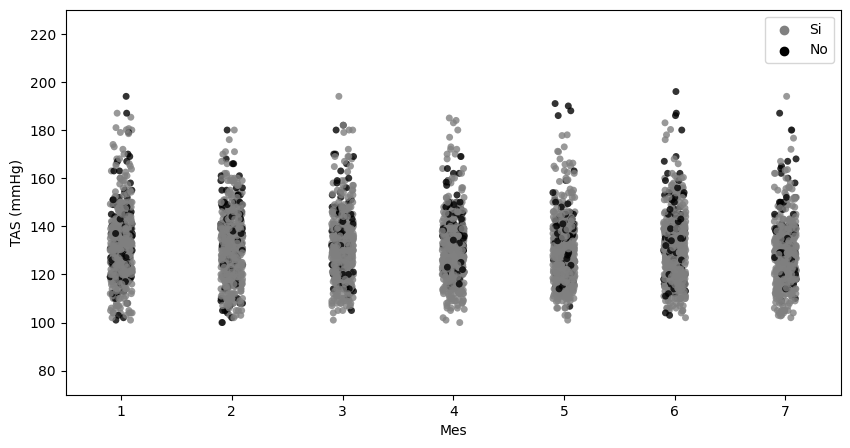

In [48]:
import seaborn.objects as so

plt.figure(figsize=(10,5))
sns.stripplot(
    x=tesis["Mes"],
    y=tesis["TAS"],
    marker="o",
    hue=tesis["Adherencia"].map({0: "No", 1: "Si"}),
    palette=["gray", "black"],
    alpha=0.8,
)
plt.ylabel("TAS (mmHg)")
plt.ylim((70, 230))
plt.legend(loc="upper right")
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo_with_adherencia_scatter.png", bbox_inches='tight')

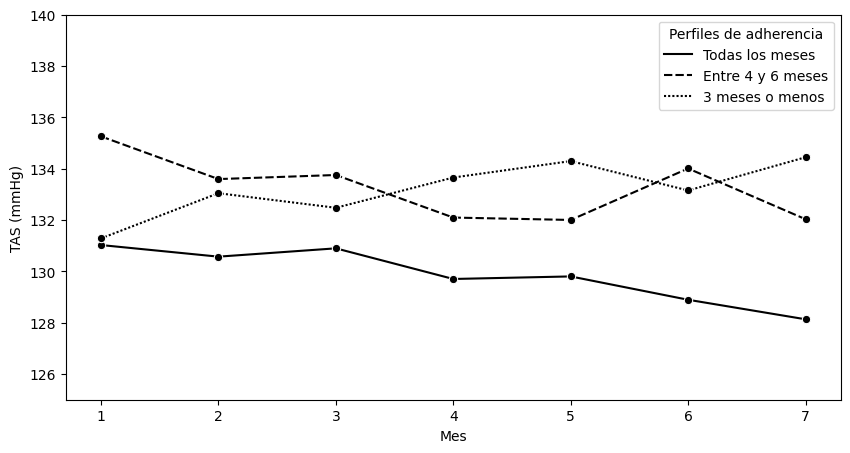

In [49]:
aux = []
for value in tesis["Adherencia_Total"]:
    if value <= 0.45:
        aux.append("3 meses o menos")
    elif value == 1:
        aux.append("Todas los meses")
    else:
        aux.append("Entre 4 y 6 meses")

tesis["Perfiles de adherencia"] = aux

plt.figure(figsize=(10,5))
sns.lineplot(
    x=tesis["Mes"],
    y=tesis["TAS"],
    marker="o",
    hue=tesis["Perfiles de adherencia"],
    style=tesis["Perfiles de adherencia"],
    palette=["black", "black", "black"],
    ci=None
)
plt.ylim(YLIM)
plt.ylabel("TAS (mmHg)")
# plt.title("Perfiles promedio de la TAS según proporción de adherencia total del tratamiento")
plt.savefig(f"{PATH_TO_IMG}/TAS_vs_tpo_with_adherencia.png", bbox_inches='tight')

tesis = tesis.drop("Perfiles de adherencia", axis=1)

### Variancia homogenea

<Axes: xlabel='Mes', ylabel='TAS'>

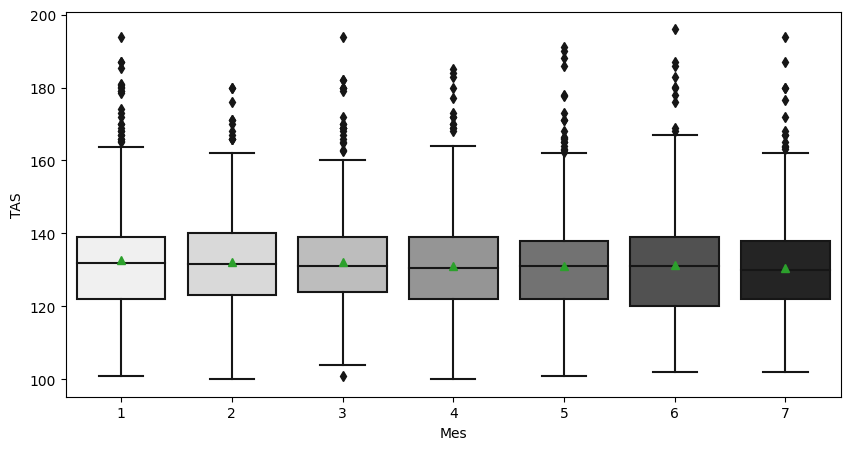

In [50]:
sns.boxplot(x=tesis["Mes"], y=tesis["TAS"], showmeans=True, palette="Greys")

### Variograma

In [51]:
effects = [
    "Intercept",
    "Sexo",
    "Edad",
    "Adherencia",
    "Mes",
    "Mes*Adherencia"
]

# mixed = MixedLM(endog=tesis["TAS"], exog=tesis[effects], groups=tesis["idPaciente"]).fit()

In [52]:
import statsmodels.api as sm
# fixed_effects = ["Intercept", "tpo_programa"]
mixed = sm.OLS(tesis["TAS"], tesis[effects]).fit()

In [53]:
def variograma(id, x, y):
    """
    id = (nobs x 1) vector con los id
    y = (nobs x 1) vector respuesta (residuos)
    x = (nobs x 1) vector de covariables (tiempo)
    
    RETURN: delta.y = vec( 0.5*(y_ij - y_ik)^2 )
            delta.x = vec( abs( x_ij - x_ik ) )
    """
    uid = id.unique()
    m = len(uid)
    delta_y = []
    delta_x = []
    did = []
    for i in range(m):
        yi = y[id == uid[i]]
        xi = x[id == uid[i]]
        n = len(yi)
        expand_j = [i for i in range(n)]*n
        expand_k = np.repeat([i for i in range(n)], n)
        keep = expand_j > expand_k
        if keep.sum() > 0:
            expand_j = [j for j, b in zip(expand_j, keep) if b]
            expand_k = [k for k, b in zip(expand_k, keep) if b]
            delta_yi = 0.5*(np.array(yi.iloc[expand_j]) - np.array(yi.iloc[expand_k]))**2
            delta_xi = abs(np.array(xi.iloc[expand_j]) - np.array(xi.iloc[expand_k]))
            didi = np.repeat(uid[i], len(delta_yi))
            delta_y.extend(list(delta_yi))
            delta_x.extend(list(delta_xi))
            did.extend(list(didi))
    return did, delta_x, delta_y

In [54]:
did, delta_x, delta_y = variograma(tesis["idPaciente"], tesis["Mes"], mixed.resid)

In [55]:
import rpy2.robjects as robjects
# INSTALL R VERSION 3.5.3

r_x = robjects.FloatVector(delta_x)
r_y = robjects.FloatVector(delta_y)

r_smooth_spline = robjects.r["smooth.spline"]

spline = r_smooth_spline( r_x, r_y, df=5 )

In [56]:
def jitter(data, factor=0.1):
    jittered_data = data + np.random.normal(0, factor, len(data))
    return jittered_data

<Figure size 1000x500 with 0 Axes>

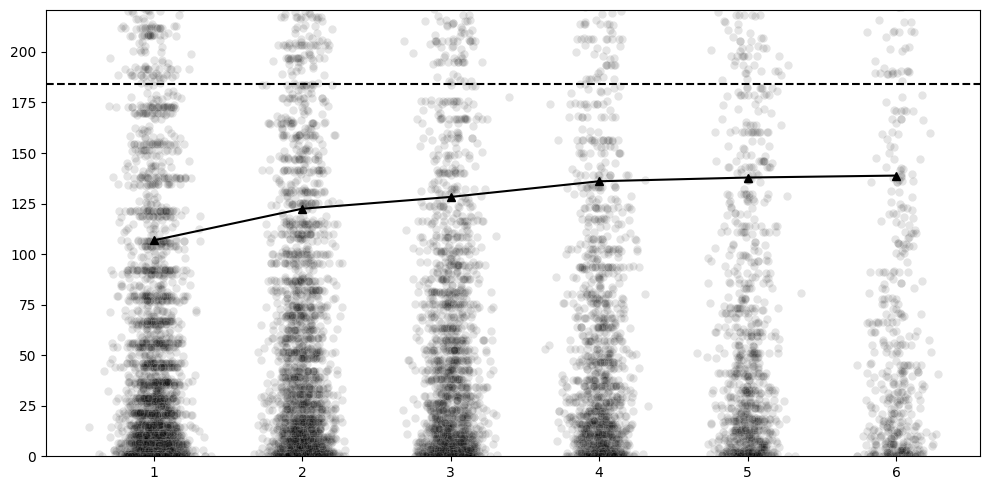

In [57]:
plt.figure(figsize=(10,5))
var = np.var(mixed.resid)
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
scat = sns.scatterplot(x=jitter(delta_x), y=delta_y, alpha=0.1)
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="black")
# plt.title("Semivariograma")
plt.tight_layout()
plt.savefig(f"{PATH_TO_IMG}/semivariogram.png", bbox_inches='tight')
# plt.show()

# Variograma R

In [58]:
cd4 = pd.read_excel("../Datos/cd4.xls")

In [59]:
cd4

,id,tiempo,CD4,edad,cigarrillos,drogas,parejas,CESD
0,10002,-0.741958,548,6.57,0,0,5,8
1,10002,-0.246407,893,6.57,0,1,5,2
2,10002,0.243669,657,6.57,0,1,5,-1
3,10005,-2.729637,464,6.95,0,1,5,4
4,10005,-2.250513,845,6.95,0,1,5,-4
...,...,...,...,...,...,...,...,...
2371,41844,0.238193,570,-5.04,4,1,0,10
2372,41844,0.772074,826,-5.04,4,1,-4,4
2373,41844,1.538672,983,-5.04,4,1,-4,8
2374,41844,2.056126,517,-5.04,4,0,-3,9


In [60]:
cd4["tiempo2"] = cd4["tiempo"]*cd4["tiempo"]
cd4["tiempo3"] = cd4["tiempo"]*cd4["tiempo"]*cd4["tiempo"]
cd4["tiempo_edad"] = cd4["tiempo"]*cd4["edad"]
cd4["tiempo2_edad"] = cd4["tiempo2"]*cd4["edad"]
cd4["tiempo3_edad"] = cd4["tiempo3"]*cd4["edad"]
cd4["intercept"] = 1

In [61]:
model = MixedLM(endog=cd4["CD4"], exog=cd4[["intercept", "edad", "tiempo", "tiempo_edad", "tiempo2", "tiempo2_edad", "tiempo3", "tiempo3_edad"]], groups=cd4["id"]).fit()

In [62]:
import statsmodels.api as sm
model = sm.OLS(cd4["CD4"], cd4[["intercept", "edad", "tiempo", "tiempo_edad", "tiempo2", "tiempo2_edad", "tiempo3", "tiempo3_edad"]]).fit()

In [63]:
def variograma(id, x, y):
    """
    id = (nobs x 1) vector con los id
    y = (nobs x 1) vector respuesta (residuos)
    x = (nobs x 1) vector de covariables (tiempo)
    
    RETURN: delta.y = vec( 0.5*(y_ij - y_ik)^2 )
            delta.x = vec( abs( x_ij - x_ik ) )
    """
    uid = id.unique()
    m = len(uid)
    delta_y = []
    delta_x = []
    did = []
    for i in range(m):
        yi = y[id == uid[i]]
        xi = x[id == uid[i]]
        n = len(yi)
        expand_j = [i for i in range(n)]*n
        expand_k = np.repeat([i for i in range(n)], n)
        keep = expand_j > expand_k
        if keep.sum() > 0:
            expand_j = [j for j, b in zip(expand_j, keep) if b]
            expand_k = [k for k, b in zip(expand_k, keep) if b]
            delta_yi = 0.5*(np.array(yi.iloc[expand_j]) - np.array(yi.iloc[expand_k]))**2
            delta_xi = abs(np.array(xi.iloc[expand_j]) - np.array(xi.iloc[expand_k]))
            didi = np.repeat(uid[i], len(delta_yi))
            delta_y.extend(list(delta_yi))
            delta_x.extend(list(delta_xi))
            did.extend(list(didi))
    return did, delta_x, delta_y

In [64]:
did, delta_x, delta_y = variograma(cd4["id"], cd4["tiempo"], model.resid)

In [65]:
import rpy2.robjects as robjects

r_x = robjects.FloatVector(delta_x)
r_y = robjects.FloatVector(delta_y)

r_smooth_spline = robjects.r["smooth.spline"]

spline = r_smooth_spline( r_x, r_y, df=5 )

In [66]:
spline[1][-1]

115541.64142428085

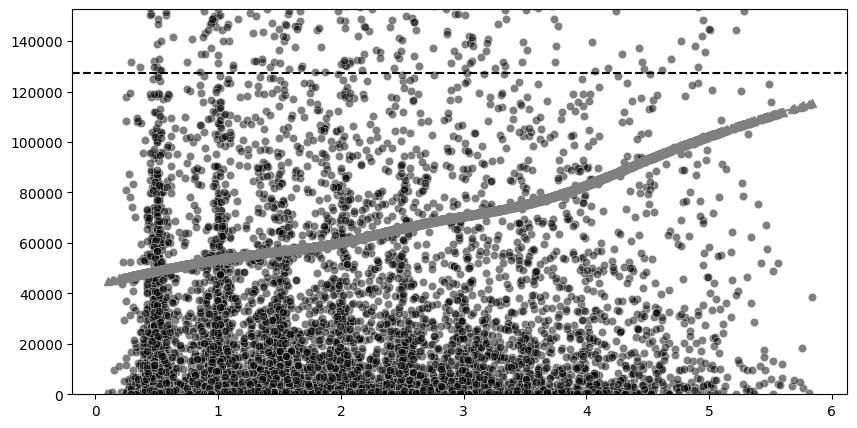

In [67]:
var = np.var(model.resid)
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
scat = sns.scatterplot(x=delta_x, y=delta_y, alpha=0.5)
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="grey")
plt.show()

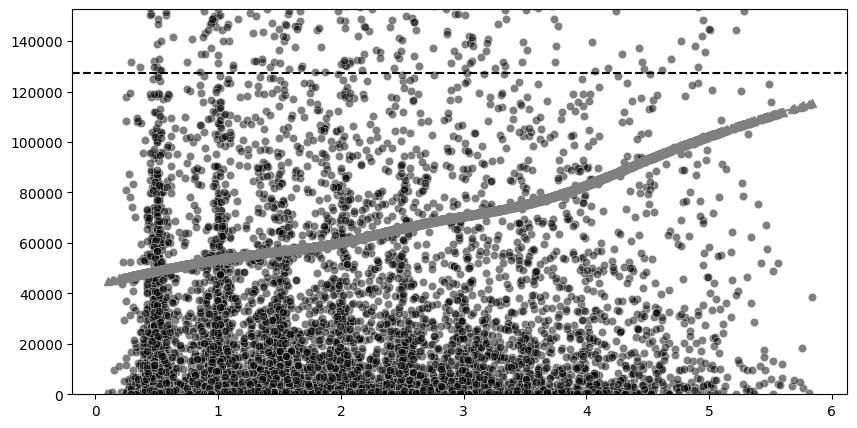

In [68]:
var = np.var(model.resid)
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
scat = sns.scatterplot(x=delta_x, y=delta_y, alpha=0.5)
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="grey")
plt.show()